### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
from qcodes.instrument_drivers.AlazarTech.acq_controllers import ATS9360Controller
from qcodes.instrument_drivers.AlazarTech.acq_controllers.alazar_channel import AlazarChannel
import qcodes.instrument_drivers.AlazarTech.acq_helpers as helpers
from qcodes.station import Station

import logging
logging.basicConfig(level=logging.INFO)

NB: See ATS9360 example notebook for general commands 

In [3]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '6.0.0',
 'asopc_type': '1645511520',
 'bits_per_sample': 12,
 'driver_version': '6.0.0',
 'firmware': None,
 'latest_cal_date': '25-01-17',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970396',
 'vendor': 'AlazarTech'}

In [4]:
# Configure all settings in the Alazar card
alazar.config(clock_source='INTERNAL_CLOCK',
              sample_rate=10_000_000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=160,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

## Example 1

Pulls the raw data the alazar acquires averaged over records and buffers.

In [5]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to. Explicitly pass the default options to the Alazar.
# Dont integrate over samples but avarage over records
myctrl = ATS9360Controller(name='my_controller', alazar_name='Alazar')

Put the Alazar and the controller in a station so we ensure that all parameters are captured

In [6]:
station = qc.Station(alazar, myctrl)

This controller is designed to be highlevel and it is not possible to directly set number of records, buffers and samples. The number of samples is indirecly controlled by the integration time and integration delay and the number of averages controls the number of buffers and records acquired

In [7]:
myctrl.channels

ChannelList(<ATS9360Controller: my_controller>, AlazarChannel, [])

In [8]:
myctrl.int_delay(2e-7)
myctrl.int_time(3.5e-5)
print(myctrl.samples_per_record())
#myctrl.num_avg(1000)

INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.ATS9360Controller:need 2.0 samples round up to 256
INFO:qcodes.instrument_drivers.AlazarTech.acq_controllers.ATS9360Controller:need 351.99999999999994 samples round up to 512


512


In [9]:
# print("{} records per buffer set by num_avg".format(myctrl.records_per_buffer()))
# print("{} samples per record set by int_time and int_delay".format(myctrl.samples_per_record()))

Per default the output will contain an array called raw_output of unprocessed data

# 1D samples trace

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


1
1000


INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (1.912905 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1000 records (1912.904702 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 2.048e+06 bytes (3.91763e+06 bytes per sec)


DataSet:
   location = 'data/2017-09-08/#013_{name}_13-34-06'
   <Type>   | <array_id>                | <array.name> | <array.shape>
   Measured | my_controller_mychan_data | data         | (512,)
acquired at 2017-09-08 13:34:07


<IPython.core.display.Javascript object>


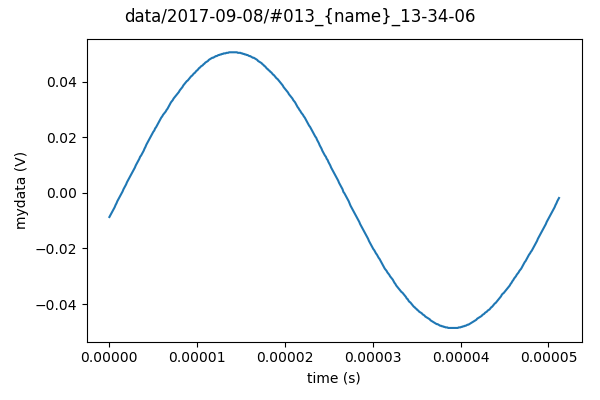

In [10]:
chan1 = AlazarChannel(myctrl, 'mychan', demod=False, integrate_samples=False)
myctrl
#chan1.samples_per_record(8192)
#chan1.records_per_buffer(100)
#chan1.buffers_per_acquisition(100)
chan1.num_averages(1000)
print(chan1.buffers_per_acquisition())
print(chan1.records_per_buffer())

chan1.alazar_channel(0)
chan1.prepare_channel()

# Measure this 
data1 = qc.Measure(chan1.data).run()
qc.MatPlot(data1.my_controller_mychan_data)

# 1D records trace

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


10
55


INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 10 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 10 buffers (21.550380 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 550 records (1185.270919 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.1264e+06 bytes (2.42743e+06 bytes per sec)


DataSet:
   location = 'data/2017-09-08/#014_{name}_13-36-30'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_data | data         | (55,)
acquired at 2017-09-08 13:36:31


<IPython.core.display.Javascript object>


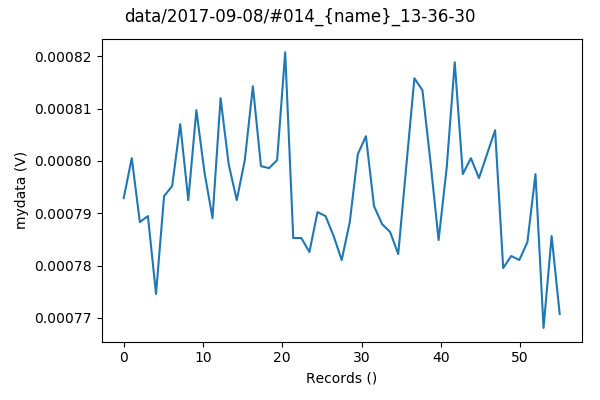

In [14]:
chan2 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_records=False)


chan2.num_averages(10)
chan2.records_per_buffer(55)
print(chan2.buffers_per_acquisition())
print(chan2.records_per_buffer())
chan2.alazar_channel(0)

chan2.prepare_channel()

# Measure this 
data2 = qc.Measure(chan2.data).run()
qc.MatPlot(data2.my_controller_myrecchan_data)

# 1D Buffer trace

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 74 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 74 buffers (64.078757 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 7400 records (6407.875671 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.51552e+07 bytes (1.31233e+07 bytes per sec)


DataSet:
   location = 'data/2017-09-08/#015_{name}_13-36-58'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_data | data         | (74,)
acquired at 2017-09-08 13:37:00


<IPython.core.display.Javascript object>


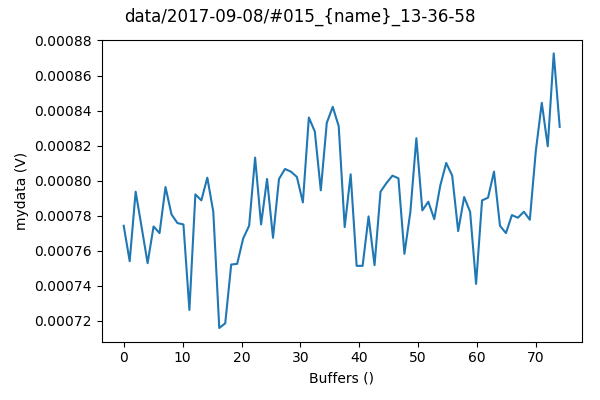

In [15]:
chan3 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_buffers=False)

chan3.num_averages(100)
chan3.buffers_per_acquisition(74)
chan3.alazar_channel(0)

chan3.prepare_channel()

# Measure this 
data3 = qc.Measure(chan3.data).run()
qc.MatPlot(data3.my_controller_myrecchan_data)

# 2D Samples vs records

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (2.172790 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 500 records (1086.394872 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.024e+06 bytes (2.22494e+06 bytes per sec)


DataSet:
   location = 'data/2017-09-08/#016_{name}_13-37-11'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_myrecvssamples_data | data         | (500, 512)
acquired at 2017-09-08 13:37:17


<IPython.core.display.Javascript object>


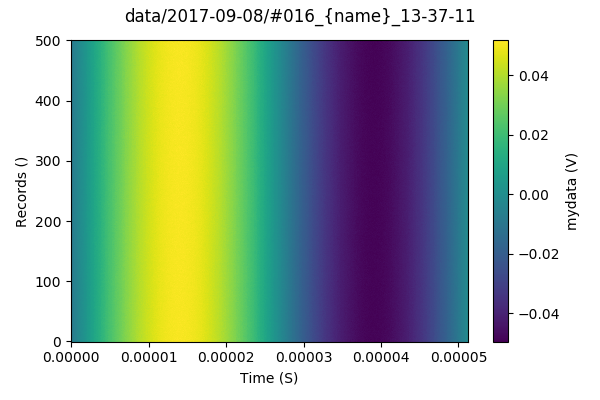

In [16]:
chan4 = AlazarChannel(myctrl, 'myrecvssamples', demod=False, average_records=False, integrate_samples=False)

chan4.records_per_buffer(500)
chan4.num_averages(1)
chan4.alazar_channel(0)
chan4.prepare_channel()
# Measure this 
data4 = qc.Measure(chan4.data).run()
qc.MatPlot(data4.my_controller_myrecvssamples_data)



# 2D Buffers vs Records

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (109.237268 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 5000 records (5461.863406 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 1.024e+07 bytes (1.11859e+07 bytes per sec)


DataSet:
   location = 'data/2017-09-08/#017_{name}_13-37-31'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Measured | my_controller_mybuffersvsrecs_data | data         | (100, 50)
acquired at 2017-09-08 13:37:33


<IPython.core.display.Javascript object>


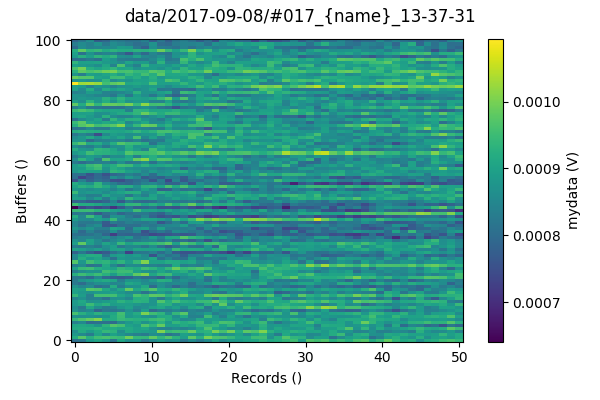

In [17]:
chan5 = AlazarChannel(myctrl, 'mybuffersvsrecs', demod=False, average_records=False, average_buffers=False)

chan5.records_per_buffer(50)
chan5.buffers_per_acquisition(100)
chan5.num_averages(1)
chan5.alazar_channel(0)
chan5.prepare_channel()
# Measure this 
data5 = qc.Measure(chan5.data).run()
qc.MatPlot(data5.my_controller_mybuffersvsrecs_data)


# 2D Buffers vs Samples

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 100 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 buffers (70.572592 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 10000 records (7057.259206 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 2.048e+07 bytes (1.44533e+07 bytes per sec)


DataSet:
   location = 'data/2017-09-08/#018_{name}_13-37-39'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_mybufvssamples_data | data         | (100, 512)
acquired at 2017-09-08 13:37:43


<IPython.core.display.Javascript object>


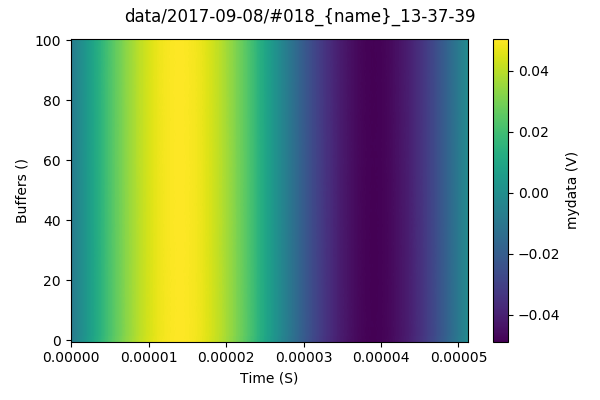

In [18]:
chan6 = AlazarChannel(myctrl, 'mybufvssamples', demod=False, average_buffers=False, integrate_samples=False)


chan6.buffers_per_acquisition(100)
chan6.num_averages(100)
chan6.alazar_channel(0)
chan6.prepare_channel()
# Measure this 
data6 = qc.Measure(chan6.data).run()
qc.MatPlot(data6.my_controller_mybufvssamples_data)



# Single point

In [20]:
chan7 = AlazarChannel(myctrl, 'mybufvssamples', demod=False)


chan7.num_averages(100)
chan7.alazar_channel(0)
chan7.prepare_channel()
# Measure this

data7 = qc.Measure(chan7.data).run()

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Capturing 1 buffers.
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 1 buffers (2.438216 buffers per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Captured 100 records (243.821581 records per sec)
INFO:qcodes.instrument_drivers.AlazarTech.ATS:Transferred 204800 bytes (499347 bytes per sec)


DataSet:
   location = 'data/2017-09-08/#019_{name}_13-38-10'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Setpoint | single_set                        | single       | (1,)
   Measured | my_controller_mybufvssamples_data | data         | (1,)
acquired at 2017-09-08 13:38:11


As we are not integrating over samples the setpoints (label, unit and ticks on number) are automatically set from the integration time and integration delay. **Note at the moment this does not cut of the int_delay from the plot. It probably should**

### Demodulation

We can add demodulators and remove them again, This will automatically take care of adapting the multiparameter to return multiple arrays to the dataset

In [12]:
myctrl.demod_freqs.add_demodulator(7e6)
myctrl.demod_freqs.add_demodulator(8e6)
myctrl.demod_freqs.add_demodulator(9e6)
myctrl.demod_freqs.add_demodulator(10e6)
myctrl.demod_freqs.add_demodulator(11e6)
myctrl.demod_freqs.add_demodulator(12e6)
myctrl.demod_freqs.add_demodulator(13e6)
print(myctrl.demod_freqs.get())

[7000000.0, 8000000.0, 9000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0]


In this example we are demodulating a 10 MHz Signal from the Tektronix AWG

In [13]:
# Do this in as qcodes measurement (ie the same but makes a data set)
data2 = qc.Measure(myctrl.acquisition).run(station=station)


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#060_{name}_15-55-39'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (1664,)
   Measured | my_controller_raw_output         | raw_output         | (1664,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (1664,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (1664,)
   Measured | my_controller_demod_freq_1_mag   | demod_freq_1_mag   | (1664,)
   Measured | my_controller_demod_freq_1_phase | demod_freq_1_phase | (1664,)
   Measured | my_controller_demod_freq_2_mag   | demod_freq_2_mag   | (1664,)
   Measured | my_controller_demod_freq_2_phase | demod_freq_2_phase | (1664,)
   Measured | my_controller_demod_freq_3_mag   | demod_freq_3_mag   | (1664,)
   Measured | my_controller_demod_freq_3_phase | demod_freq_3_phase | (1664,)
   Measured | my_controller_demod_freq_4_mag 

<IPython.core.display.Javascript object>


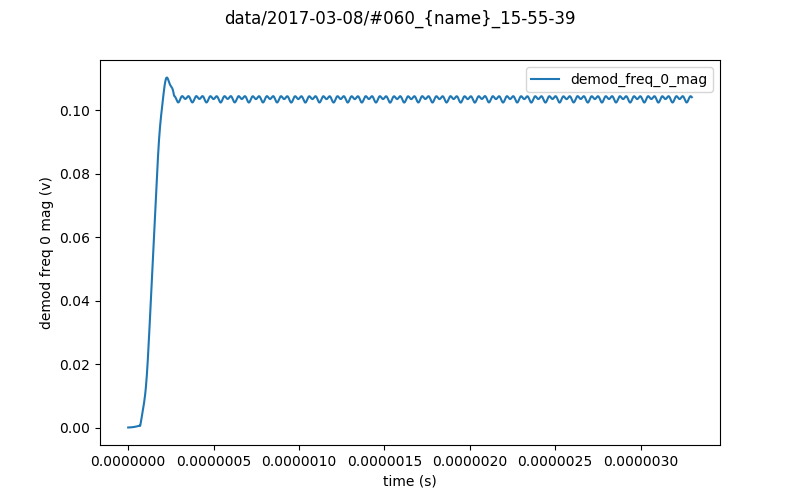

In [47]:
plot = qc.MatPlot()
plot.add(data2.my_controller_demod_freq_0_mag)
plot.fig.axes[0].legend()

<IPython.core.display.Javascript object>


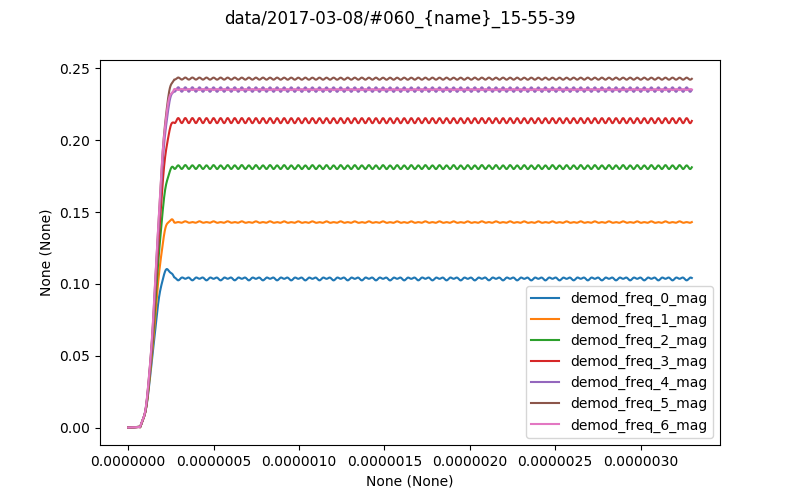

In [14]:
plot = qc.MatPlot(data2.my_controller_demod_freq_0_mag)
plot.add(data2.my_controller_demod_freq_1_mag)
plot.add(data2.my_controller_demod_freq_2_mag)
plot.add(data2.my_controller_demod_freq_3_mag)
plot.add(data2.my_controller_demod_freq_4_mag)
plot.add(data2.my_controller_demod_freq_5_mag)
plot.add(data2.my_controller_demod_freq_6_mag)
plot.fig.axes[0].legend()

There is currently a bug when plotting more than one lineplot the labels are missing

It's possible to change int_time, int_delay and num_avg in an already created acq_controller

In [15]:
myctrl.int_delay(2e-7)
myctrl.int_time(3e-6)
myctrl.num_avg(1)

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-07/#032_{name}_12-36-13'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (3200,)
   Measured | my_controller_raw_output         | raw_output         | (3200,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (3200,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (3200,)
acquired at 2017-03-07 12:36:14


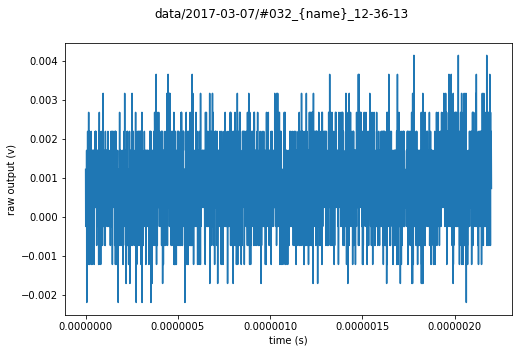

In [16]:
data3 = qc.Measure(myctrl.acquisition).run()
plot = qc.MatPlot(data3.my_controller_raw_output)
plot.fig

Assuming that you have establised the correct int time and delay we can integrate over samples. To change averaging and integrating setting you currently have to create a new controller

## Example 2

We can also chose to not average over records. You currently have to either integrate over samples or average over records (the returned data must be 1D)

In [16]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
myintctrl = ATS9360Controller(name='my_controller_int', alazar_name='Alazar', integrate_samples=True)

In [17]:
myintctrl.int_delay(2e-7)
myintctrl.int_time(3e-6)
myintctrl.num_avg(100)

In [18]:
data4 = qc.Measure(myintctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#061_{name}_16-00-40'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Setpoint | single_set                   | single       | (1,)
   Measured | my_controller_int_raw_output | raw_output   | (1,)
acquired at 2017-03-08 16:00:40


We can add the same demodulator freqs and look at the integrated samples 

In [19]:
myintctrl.demod_freqs.add_demodulator(7e6)
myintctrl.demod_freqs.add_demodulator(8e6)
myintctrl.demod_freqs.add_demodulator(9e6)
myintctrl.demod_freqs.add_demodulator(10e6)
myintctrl.demod_freqs.add_demodulator(11e6)
myintctrl.demod_freqs.add_demodulator(12e6)
myintctrl.demod_freqs.add_demodulator(13e6)
print(myintctrl.demod_freqs.get())


[7000000.0, 8000000.0, 9000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0]


In [20]:
data5 = qc.Measure(myintctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#062_{name}_16-00-42'
   <Type>   | <array_id>                           | <array.name>       | <array.shape>
   Setpoint | single_set                           | single             | (1,)
   Measured | my_controller_int_raw_output         | raw_output         | (1,)
   Measured | my_controller_int_demod_freq_0_mag   | demod_freq_0_mag   | (1,)
   Measured | my_controller_int_demod_freq_0_phase | demod_freq_0_phase | (1,)
   Measured | my_controller_int_demod_freq_1_mag   | demod_freq_1_mag   | (1,)
   Measured | my_controller_int_demod_freq_1_phase | demod_freq_1_phase | (1,)
   Measured | my_controller_int_demod_freq_2_mag   | demod_freq_2_mag   | (1,)
   Measured | my_controller_int_demod_freq_2_phase | demod_freq_2_phase | (1,)
   Measured | my_controller_int_demod_freq_3_mag   | demod_freq_3_mag   | (1,)
   Measured | my_controller_int_demod_freq_3_phase | demod_freq_3_phase | (1,)
   Measured | my_controller_int

We can also chose to not average over records. You currently have to either integrate over samples or average over records (the returned data must be 1D)

In [21]:
print(data5.my_controller_int_demod_freq_0_mag)
print(data5.my_controller_int_demod_freq_1_mag)
print(data5.my_controller_int_demod_freq_2_mag)
print(data5.my_controller_int_demod_freq_3_mag)
print(data5.my_controller_int_demod_freq_4_mag)
print(data5.my_controller_int_demod_freq_5_mag)
print(data5.my_controller_int_demod_freq_6_mag)

DataArray[1]: my_controller_int_demod_freq_0_mag
array([ 0.1037831])
DataArray[1]: my_controller_int_demod_freq_1_mag
array([ 0.14285908])
DataArray[1]: my_controller_int_demod_freq_2_mag
array([ 0.18105679])
DataArray[1]: my_controller_int_demod_freq_3_mag
array([ 0.21327569])
DataArray[1]: my_controller_int_demod_freq_4_mag
array([ 0.23483571])
DataArray[1]: my_controller_int_demod_freq_5_mag
array([ 0.24245093])
DataArray[1]: my_controller_int_demod_freq_6_mag
array([ 0.23493526])


As we can see the integrated samples seems consistent with the plots above.

## Example 3

In the last example we are running the AWG in sequencing mode. To do this we need to change the trigger to setup to enable a secondary trigger on the aux input. We change the alazar config here. 

In [48]:
alazar.config(clock_source='INTERNAL_CLOCK',
              sample_rate=500000000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=160,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_TRIGGER_ENABLE', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='TRIG_SLOPE_POSITIVE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

In [24]:
myrecctrl = ATS9360Controller(name='my_controller_rec', alazar_name='Alazar', 
                              integrate_samples=True, average_records=False)

KeyError: 'Another instrument has the name: my_controller_rec'

When not averaging over records averaging is implemented by averaging over buffers and records_per_buffer can be set independently 

In [28]:
myrecctrl.int_delay(2e-7)
myrecctrl.int_time(3e-6)
myrecctrl.num_avg(100)
myrecctrl.records_per_buffer(8)
data6 = qc.Measure(myrecctrl.acquisition).run()


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#065_{name}_16-19-12'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Setpoint | record_num_set               | record_num   | (8,)
   Measured | my_controller_rec_raw_output | raw_output   | (8,)
acquired at 2017-03-08 16:19:13


Here we are changing the driving freq of the AWG between the freqs below. We demodulate with the same frequencies in 8 records

In [49]:
demod_freqs = [5e6, 7e6, 9e6, 11e6, 13e6, 15e6, 17e6, 19e6]

In [32]:
for freq in demod_freqs:
    myrecctrl.demod_freqs.add_demodulator(freq)

As the setpoints along a records axis is expected to be dependent on an external instrument
which the driver has no way of knowing there is support for setting the base name, unit and start and stop of setpoints (the number of setpoints is automatically set from the number of records) as shown below

In [40]:
myrecctrl.acquisition.set_base_setpoints(base_name='awg_freq', base_label='awg freq', base_unit='Hz',
                             setpoints_start=5e6, setpoints_stop = 19e6)
data6 = qc.Measure(myrecctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#069_{name}_16-29-43'
   <Type>   | <array_id>                           | <array.name>       | <array.shape>
   Setpoint | awg_freq_set                         | awg_freq           | (8,)
   Measured | my_controller_rec_raw_output         | raw_output         | (8,)
   Measured | my_controller_rec_demod_freq_0_mag   | demod_freq_0_mag   | (8,)
   Measured | my_controller_rec_demod_freq_0_phase | demod_freq_0_phase | (8,)
   Measured | my_controller_rec_demod_freq_1_mag   | demod_freq_1_mag   | (8,)
   Measured | my_controller_rec_demod_freq_1_phase | demod_freq_1_phase | (8,)
   Measured | my_controller_rec_demod_freq_2_mag   | demod_freq_2_mag   | (8,)
   Measured | my_controller_rec_demod_freq_2_phase | demod_freq_2_phase | (8,)
   Measured | my_controller_rec_demod_freq_3_mag   | demod_freq_3_mag   | (8,)
   Measured | my_controller_rec_demod_freq_3_phase | demod_freq_3_phase | (8,)
   Measured | my_controller_rec

<IPython.core.display.Javascript object>


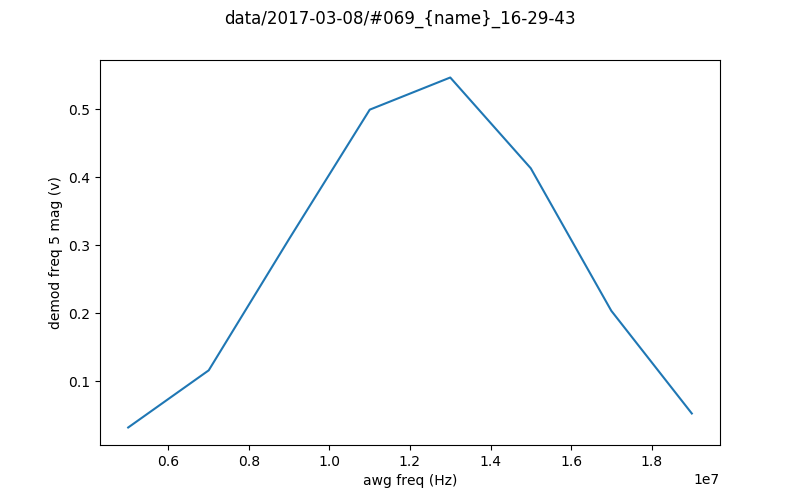

In [51]:
plot = qc.MatPlot(data6.my_controller_rec_demod_freq_5_mag)

<IPython.core.display.Javascript object>


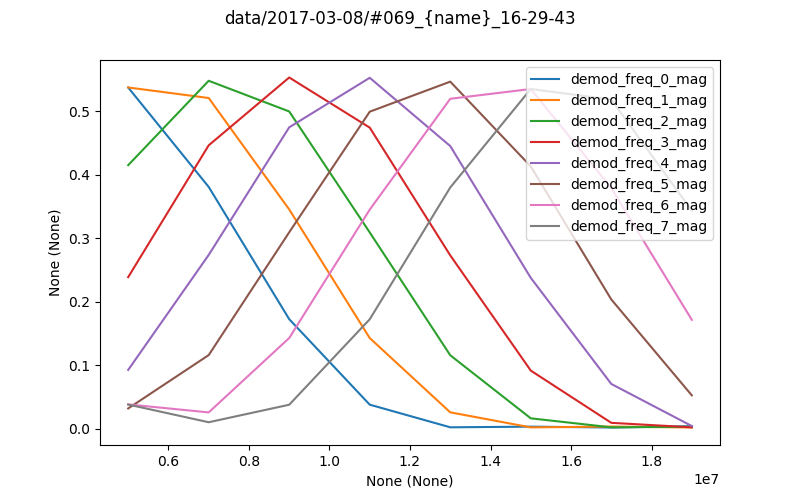

In [50]:
plot = qc.MatPlot(data6.my_controller_rec_demod_freq_0_mag)
plot.add(data6.my_controller_rec_demod_freq_1_mag)
plot.add(data6.my_controller_rec_demod_freq_2_mag)
plot.add(data6.my_controller_rec_demod_freq_3_mag)
plot.add(data6.my_controller_rec_demod_freq_4_mag)
plot.add(data6.my_controller_rec_demod_freq_5_mag)
plot.add(data6.my_controller_rec_demod_freq_6_mag)
plot.add(data6.my_controller_rec_demod_freq_7_mag)
plot.fig.axes[0].legend()

In [16]:
class Demodulator:



    def __init__(self,
                 buffers_per_acquisition: int,
                 records_per_buffer: int,
                 samples_per_record: int,
                 sample_rate: float,
                 filter_settings,
                 active_channels):

        self.filter_settings = filter_settings
        self.active_channels = active_channels
        self.sample_rate = sample_rate
        settings = active_channels[0]
        if settings['average_buffers']:
            len_buffers = 1
        else:
            len_buffers = buffers_per_acquisition

        if settings['average_records']:
            len_records = 1
        else:
            len_records = records_per_buffer

        num_demods = 1
        demod_freqs = np.array(settings['demod_freq'])
        mat_shape = (num_demods, len_buffers,
                     len_records, samples_per_record)
        self.mat_shape = mat_shape
        integer_list = np.arange(samples_per_record)
        integer_mat = (np.outer(np.ones(len_buffers),
                                np.outer(np.ones(len_records), integer_list)))
        angle_mat = 2 * np.pi * \
                    np.outer(demod_freqs, integer_mat).reshape(mat_shape) / sample_rate
        self.cos_mat = np.cos(angle_mat)
        self.sin_mat = np.sin(angle_mat)


    def demodulate(self, volt_rec, int_delay, int_time):
        """
        Applies low bandpass filter and demodulation fit,
        and integration limits to samples array

        Args:
            record (numpy array): record from alazar to be multiplied
                                  with the software signal, filtered and limited
                                  to ifantegration limits shape = (samples_taken, )

        Returns:
            magnitude (numpy array): shape = (demod_length, samples_after_limiting)
            phase (numpy array): shape = (demod_length, samples_after_limiting)
        """

        # volt_rec to matrix and multiply with demodulation signal matrices
        demod_length = 1 #self.demod_freqs.get_num_demods()
        volt_rec_mat = np.outer(np.ones(demod_length), volt_rec).reshape(self.mat_shape)
        re_mat = np.multiply(volt_rec_mat, self.cos_mat)
        im_mat = np.multiply(volt_rec_mat, self.sin_mat)*0

        # filter out higher freq component
        cutoff = self.active_channels[0]['demod_freq']/10
        # self.demod_freqs.get_max_demod_freq() / 10
        if self.filter_settings['filter'] == 0:
            re_filtered = helpers.filter_win(re_mat, cutoff,
                                             self.sample_rate,
                                             self.filter_settings['numtaps'],
                                             axis=-1)
            im_filtered = helpers.filter_win(im_mat, cutoff,
                                             self.sample_rate,
                                             self.filter_settings['numtaps'],
                                             axis=-1)
        elif self.filter_settings['filter'] == 1:
            re_filtered = helpers.filter_ls(re_mat, cutoff,
                                            self.sample_rate,
                                            self.filter_settings['numtaps'],
                                            axis=-1)
            im_filtered = helpers.filter_ls(im_mat, cutoff,
                                            self.sample_rate,
                                            self.filter_settings['numtaps'],
                                            axis=-1)
        elif self.filter_settings['filter'] == 2:
            re_filtered = re_mat
            im_filtered = im_mat
        else:
            raise RuntimeError("Filter setting: {} not implemented".format(self.filter_settings['filter']))

        if self.active_channels[0]['integrate_samples']:
            # apply integration limits
            beginning = int(int_delay * self.sample_rate)
            end = beginning + int(int_time * self.sample_rate)

            re_limited = re_filtered[..., beginning:end]
            im_limited = im_filtered[..., beginning:end]
        else:
            re_limited = re_filtered
            im_limited = im_filtered

        # convert to magnitude and phase
        complex_mat = re_limited + im_limited * 1j
        magnitude = abs(complex_mat)
        phase = np.angle(complex_mat, deg=True)

        
        return magnitude, phase

In [87]:
myctrl.close()
alazar.close()